In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"livia07","key":"85c2abdbb50114e97fce0d2db473bbb6"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [3]:
!kaggle datasets download -d andot03bsrc/dataset-predic-terkena-penyakit-paruparu

Dataset URL: https://www.kaggle.com/datasets/andot03bsrc/dataset-predic-terkena-penyakit-paruparu
License(s): unknown
  0% 0.00/104k [00:00<?, ?B/s]
100% 104k/104k [00:00<00:00, 58.0MB/s]


In [4]:
!unzip dataset-predic-terkena-penyakit-paruparu.zip -d dataset-predic-terkena-penyakit-paruparu
!ls dataset-predic-terkena-penyakit-paruparu

Archive:  dataset-predic-terkena-penyakit-paruparu.zip
  inflating: dataset-predic-terkena-penyakit-paruparu/predic_tabel.csv  
predic_tabel.csv


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score

import seaborn as sns
from keras.layers import Dense, BatchNormalization, Dropout, LSTM
from keras.models import Sequential
from keras.utils import to_categorical
from keras import callbacks
from tensorflow.keras.optimizers import Adam

import tensorflow as tf

In [24]:
data = pd.read_csv('/content/dataset-predic-terkena-penyakit-paruparu/predic_tabel.csv')

In [25]:
data.head()

No  Usia Jenis_Kelamin Merokok Bekerja Rumah_Tangga Aktivitas_Begadang  \
0   1   Tua          Pria   Pasif   Tidak           Ya                 Ya   
1   2   Tua          Pria   Aktif   Tidak           Ya                 Ya   
2   3  Muda          Pria   Aktif   Tidak           Ya                 Ya   
3   4   Tua          Pria   Aktif      Ya        Tidak              Tidak   
4   5  Muda        Wanita   Pasif      Ya        Tidak              Tidak   

  Aktivitas_Olahraga Asuransi Penyakit_Bawaan  Hasil  
0             Sering      Ada           Tidak     Ya  
1             Jarang      Ada             Ada  Tidak  
2             Jarang      Ada           Tidak  Tidak  
3             Jarang      Ada             Ada  Tidak  
4             Sering    Tidak             Ada     Ya

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   No                  30000 non-null  int64 
 1   Usia                30000 non-null  object
 2   Jenis_Kelamin       30000 non-null  object
 3   Merokok             30000 non-null  object
 4   Bekerja             30000 non-null  object
 5   Rumah_Tangga        30000 non-null  object
 6   Aktivitas_Begadang  30000 non-null  object
 7   Aktivitas_Olahraga  30000 non-null  object
 8   Asuransi            30000 non-null  object
 9   Penyakit_Bawaan     30000 non-null  object
 10  Hasil               30000 non-null  object
dtypes: int64(1), object(10)
memory usage: 2.5+ MB


In [27]:
data.drop(columns=['No'], inplace=True)

In [28]:
col_names = ['Usia', 'Jenis_Kelamin', 'Merokok', 'Bekerja', 'Rumah_Tangga', 'Aktivitas_Begadang', 'Aktivitas_Olahraga', 'Asuransi', 'Penyakit_Bawaan', 'Hasil']

for col in col_names:
    print (data[col].value_counts())

Usia
Muda    15383
Tua     14617
Name: count, dtype: int64
Jenis_Kelamin
Wanita    22225
Pria       7775
Name: count, dtype: int64
Merokok
Aktif    15210
Pasif    14790
Name: count, dtype: int64
Bekerja
Ya       18964
Tidak    11036
Name: count, dtype: int64
Rumah_Tangga
Ya       15425
Tidak    14575
Name: count, dtype: int64
Aktivitas_Begadang
Ya       17548
Tidak    12452
Name: count, dtype: int64
Aktivitas_Olahraga
Jarang    17994
Sering    12006
Name: count, dtype: int64
Asuransi
Ada      21239
Tidak     8761
Name: count, dtype: int64
Penyakit_Bawaan
Ada      19350
Tidak    10650
Name: count, dtype: int64
Hasil
Tidak    15648
Ya       14352
Name: count, dtype: int64


In [29]:
numerical = []
catgcols =[]

for col in data.columns:
  if data[col].dtype=="float64":
    numerical.append(col)
  else:
    catgcols.append(col)

for col in data.columns:
  if col in numerical:
    data[col].fillna(data[col].median(), inplace=True)
  else:
    data[col].fillna(data[col].mode()[0], inplace=True)

In [30]:
le = LabelEncoder()

for col in catgcols:
    data[col] = le.fit_transform(data[col])

In [31]:
X = data.drop("Hasil",axis=1)
y = pd.get_dummies(data['Hasil'])

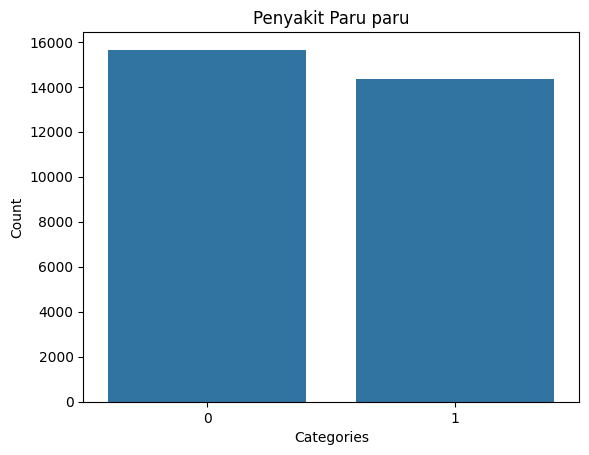

In [32]:
sns.countplot(data=data, x='Hasil')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Penyakit Paru paru')
plt.show()

In [33]:
col_names = list(X.columns)
s_scaler = preprocessing.StandardScaler()
X_df= s_scaler.fit_transform(X)
X_df = pd.DataFrame(X_df, columns=col_names)

In [34]:
X_df.describe().T

count          mean       std       min       25%  \
Usia                30000.0 -1.115552e-16  1.000017 -0.974784 -0.974784   
Jenis_Kelamin       30000.0  2.865856e-17  1.000017 -1.690716 -1.690716   
Merokok             30000.0 -3.789561e-18  1.000017 -0.986097 -0.986097   
Bekerja             30000.0 -2.368476e-19  1.000017 -1.310868 -1.310868   
Rumah_Tangga        30000.0  1.894781e-18  1.000017 -1.028746 -1.028746   
Aktivitas_Begadang  30000.0 -4.263256e-18  1.000017 -1.187119 -1.187119   
Aktivitas_Olahraga  30000.0  1.800042e-17  1.000017 -0.816837 -0.816837   
Asuransi            30000.0  4.168517e-17  1.000017 -0.642258 -0.642258   
Penyakit_Bawaan     30000.0  1.290819e-17  1.000017 -0.741881 -0.741881   

                         50%       75%       max  
Usia               -0.974784  1.025868  1.025868  
Jenis_Kelamin       0.591465  0.591465  0.591465  
Merokok            -0.986097  1.014099  1.014099  
Bekerja             0.762853  0.762853  0.762853  
Rumah_Tangga        0.972057  0.972057  0.972057  
Aktivitas_Begadang  0.842376  0.842376  0.842376  
Aktivitas_Olahraga -0.816837  1.224235  1.224235  
Asuransi           -0.642258  1.557006  1.557006  
Penyakit_Bawaan    -0.741881  1.347925  1.347925

In [35]:
X_train, X_test, y_train,y_test = train_test_split(X_df,y,test_size=0.25,random_state=7)

In [36]:
print(f"Shape of X_train is: {X_train.shape}")
print(f"Shape of y_train is: {y_train.shape}\n")
print(f"Shape of X_test is: {X_test.shape}")
print(f"Shape of y_test is: {y_test.shape}")

Shape of X_train is: (22500, 9)
Shape of y_train is: (22500, 2)

Shape of X_test is: (7500, 9)
Shape of y_test is: (7500, 2)


In [37]:
input_dim = X.shape[1]

In [38]:
model = Sequential()
model.add(Dense(8, input_dim = input_dim, kernel_initializer='normal', activation='relu'))
model.add(Dense(5, activation = "relu", kernel_initializer='normal'))
model.add(Dense(2, activation = 'sigmoid'))

In [39]:
model.compile(optimizer = Adam(learning_rate = 0.001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 80        
                                                                 
 dense_1 (Dense)             (None, 5)                 45        
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
Total params: 137 (548.00 Byte)
Trainable params: 137 (548.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [41]:
result = model.fit(X_train, y_train, epochs = 15, batch_size = 10)

Epoch 1/15
2250/2250 [==============================] - 7s 3ms/step - loss: 0.1519 - accuracy: 0.9368
Epoch 2/15
2250/2250 [==============================] - 5s 2ms/step - loss: 0.0827 - accuracy: 0.9445
Epoch 3/15
2250/2250 [==============================] - 5s 2ms/step - loss: 0.0821 - accuracy: 0.9448
Epoch 4/15
2250/2250 [==============================] - 6s 3ms/step - loss: 0.0819 - accuracy: 0.9458
Epoch 5/15
2250/2250 [==============================] - 5s 2ms/step - loss: 0.0816 - accuracy: 0.9467
Epoch 6/15
2250/2250 [==============================] - 6s 2ms/step - loss: 0.0818 - accuracy: 0.9452
Epoch 7/15
2250/2250 [==============================] - 5s 2ms/step - loss: 0.0820 - accuracy: 0.9464
Epoch 8/15
2250/2250 [==============================] - 5s 2ms/step - loss: 0.0818 - accuracy: 0.9464
Epoch 9/15
2250/2250 [==============================] - 6s 3ms/step - loss: 0.0817 - accuracy: 0.9465
Epoch 10/15
2250/2250 [==============================] - 4s 2ms/step - loss: 0.081

In [42]:
y_pred =model.predict(X_test)
y_pred = (y_pred>0.5)

235/235 [==============================] - 0s 2ms/step


In [43]:
accuracy = accuracy_score(y_test,y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.9468


In [44]:
model.save('./paru.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [45]:
model = tf.keras.models.load_model('./paru.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
open("./paru.tflite", "wb").write(tflite_model)

2612